# Data exploration
This notebook aims to study the structure of the given raw data. Data cleaning, feature engineering and domain knowledge considerations are also part of this study.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from diamond import data

## Loading and prelimiaries
Data is loaded and quickly inspected.

In [2]:
df = data.load_raw('datasets/diamonds/diamonds.csv')

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float64
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float64
 5   table    5000 non-null   float64
 6   price    5000 non-null   int64  
 7   x        5000 non-null   float64
 8   y        5000 non-null   float64
 9   z        5000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 390.8+ KB
None


,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.10,Ideal,H,SI2,62.0,55.0,4733,6.61,6.65,4.11
1,1.29,Ideal,H,SI1,62.6,56.0,6424,6.96,6.93,4.35
2,1.20,Premium,I,SI1,61.1,58.0,5510,6.88,6.80,4.18
3,1.50,Ideal,F,SI1,60.9,56.0,8770,7.43,7.36,4.50
4,0.90,Very Good,F,VS2,61.7,57.0,4493,6.17,6.21,3.82


Are there missing values?

In [3]:
df.isna().any().any()

False

Visual inspection of the data shows that a low number of decimal values is considered. All appropriate values are converted to single precision floating point, which comes without loss of information in this case. Prices are also converted to floating point values, in order to be more manageable by machine learning tools later in the pipeline.

In [4]:
df = df.astype({
    'carat': np.float32,
    'depth': np.float32,
    'table': np.float32,
    'price': np.float32,
    'x': np.float32,
    'y': np.float32,
    'z': np.float32,
})

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    5000 non-null   float32
 1   cut      5000 non-null   object 
 2   color    5000 non-null   object 
 3   clarity  5000 non-null   object 
 4   depth    5000 non-null   float32
 5   table    5000 non-null   float32
 6   price    5000 non-null   float32
 7   x        5000 non-null   float32
 8   y        5000 non-null   float32
 9   z        5000 non-null   float32
dtypes: float32(7), object(3)
memory usage: 254.0+ KB


Let's see the account value of Don Francesco's investments. This will come handy when making scalability considerations.

In [6]:
print('total diamonds value:', df.price.sum())

total diamonds value: 19627696.0


## Cleanup
Observing some statistics, it is possible to immediately spot invalid samples. The *cut*, *color* and *clarity* features will be examined later, given that they are encoded using human names.

In [7]:
df.describe()

,carat,depth,table,price,x,y,z
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.794486,61.711662,57.447063,3925.539307,5.725188,5.727744,3.533076
std,0.468424,1.446206,2.258999,3975.452148,1.119156,1.112106,0.690334
min,0.230000,44.000000,51.599998,-1.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,936.000000,4.700000,4.710000,2.900000
50%,0.700000,61.799999,57.000000,2392.500000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5369.250000,6.540000,6.540000,4.030000
max,4.130000,70.199997,95.000000,18787.000000,10.000000,9.850000,6.430000


From the source of the dataset ([diamonds.csv](datasets/diamonds/README.md)) we know that *depth* and *table* are computed as percentages. Actual measurements (*x*, *y*, *z*) are realistically represented in millimiters, according to [GIA] reports. Measures are reported with two decimals. Negative values and values below 0.01 can be scrapped.

[GIA]: https://4cs.gia.edu/en-us/diamond-buying-guide/

In [8]:
df = data.clean(df)
df.describe()

,carat,depth,table,price,x,y,z
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,0.794117,61.710838,57.446243,3930.581787,5.726232,5.728821,3.533678
std,0.467981,1.445563,2.259752,3970.923096,1.116257,1.109167,0.688437
min,0.230000,44.000000,51.599998,351.000000,3.860000,3.840000,1.410000
25%,0.400000,61.000000,56.000000,942.000000,4.700000,4.710000,2.900000
50%,0.700000,61.799999,57.000000,2398.000000,5.690000,5.700000,3.530000
75%,1.040000,62.500000,59.000000,5376.000000,6.540000,6.540000,4.030000
max,4.130000,70.199997,95.000000,18787.000000,10.000000,9.850000,6.430000


Minimal measures and pricing are now realistic. Indeed, it looks like 0 sized and negative priced diamonds were isolated dirty outliers.

## Sequential or categorical?
*Cut*, *color* and *clarity* are three of the 4Cs. According to [GIA], each of them has a scale of desirability.

In particular, the cut grade is classified as:
* Excellent
* Very good
* Good
* Fair
* Poor

Color is classified using a scale from D to Z (D is most desirable). Colors after Z are classified as *fancy color*, and are to be considered outside of the desirability scale (considered separately).

Clarity is classified through eleven specific grades, grouped in six categories:
* Flawless (FL)
* Internally Flawless (IF)
* Very, Very Slightly Included (VVS1 and VVS2)
* Very Slightly Included (VS1 and VS2)
* Slightly Included (SI1 and SI2)
* Included (I1, I2, and I3)

[GIA]: https://4cs.gia.edu/en-us/4cs-diamond-quality/

Visual inspection of the data suggests that these grades were used. Let's take a deeper look.

In [9]:
print('Unique cut grades', *df.cut.unique(), sep=', ')
print('Unique colors', *df.color.unique(), sep=', ')
print('Unique clarities', *df.clarity.unique(), sep=', ')

Unique cut grades, Ideal, Premium, Very Good, Good, Fair
Unique colors, H, I, F, G, E, D, J
Unique clarities, SI2, SI1, VS2, IF, VVS2, VS1, I1, VVS1


First of all, the collection of Don Francesco does not include all the variants. For instance, there are no diamonds of color K or worse, nor poorly graded cuts. Moreover, it looks like the cuts were graded using a slightly different scale, using *Ideal* and *Premium* grades instead of *Excellent* (there is [some feedback about it on the web](https://www.loosediamondsreviews.com/diamondcut.html)).

In order to provide the correct ordering of these grades, it seems reasonable to encode them into sequential values. With scalability in mind, the full range of grades for each of the three Cs are considered.

In [10]:
df.cut = data.cut_grades_encoder.fit_transform(df[['cut']])
df.color = data.color_encoder.fit_transform(df[['color']])
df.clarity = data.clarity_encoder.fit_transform(df[['clarity']])

In [11]:
df[["cut", "color", "clarity"]].describe()

,cut,color,clarity
count,4989.000000,4989.000000,4989.000000
mean,3.900581,19.392464,5.059130
std,1.122123,1.691265,1.631902
min,1.000000,16.000000,2.000000
25%,3.000000,18.000000,4.000000
50%,4.000000,19.000000,5.000000
75%,5.000000,21.000000,6.000000
max,5.000000,22.000000,9.000000


## Feature distributions and relations
Let's take a look at the feature distributions and their correlations. Later on, new features will be extracted from the given ones in an effort to understand correlations phenomena.

To prevent forms of leakage, in-depth studies on distributions shall be performed on a training split of the original data. A holdout of 20% is kept for testing purposes on the final model.

In [12]:
df, holdout = data.split(df)
print('train split size:', len(df), '\nholdout size:', len(holdout))

train split size: 3991 
holdout size: 998


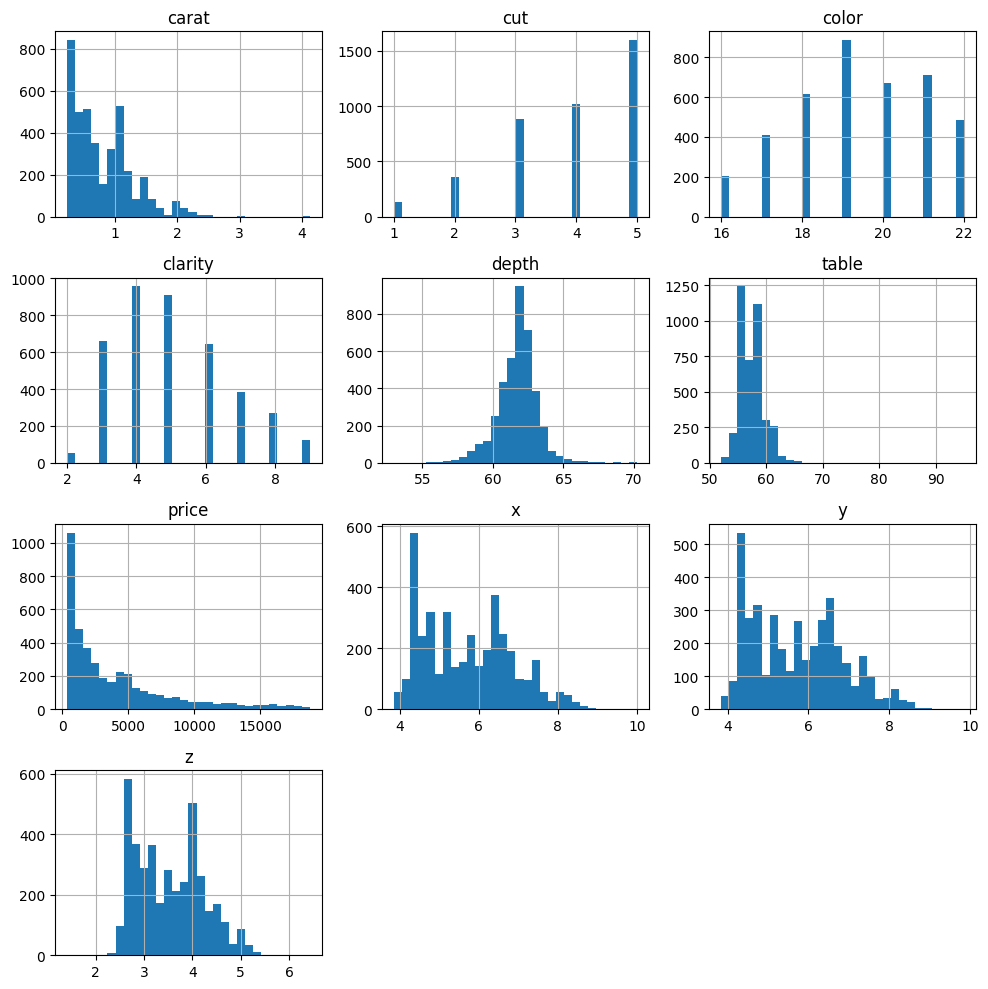

In [13]:
df.hist(figsize=(10, 10), bins=30)
plt.tight_layout()
plt.show()

Don Francesco prefers diamonds with good cuts and colors. Prices follow some tailed distribution, similar to an exponential distribution. *Depth* and *table* are seamingly gaussian distributed, with some outliers. Absolute measures (*x*, *y*, *z*) seem quite correlated to the *carats*. There is a small peak of diamonds weighting ~1 carat, which reflects onto price and dimensions as well. The 1 carat phenomenon can be brought back to the popularity of 1 carat jewelry, such as engagement rings.

Taking a look at a correlation matrix confirms some of these observations.

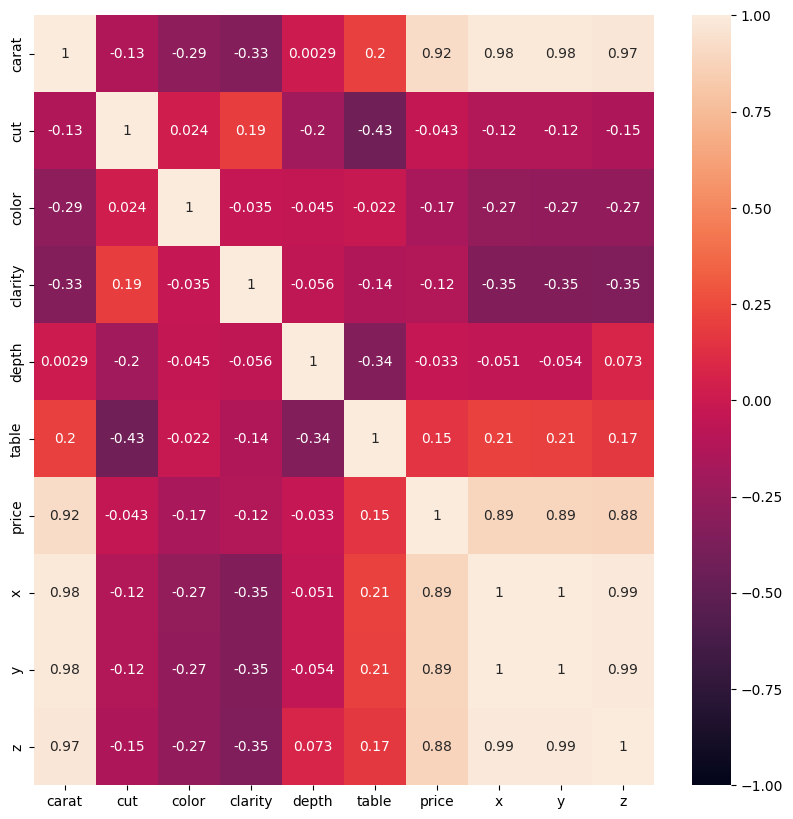

In [14]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1)
plt.show()

The plot shows a very strong correlation between absolute dimensions, carat and price. On the other hand, the other three Cs display some form of inverse correlation with the price and carat. We would expect the 3Cs to have a direct and strong correlation with the price instead. This must be connected to the peculiar collection of Don Francesco, which shows larger diamonds of generally lower quality.

### Carats and volume
The visual similarity between absolute measures' distributions and the carats distribution suggests that carats are related to the size of the diamond. This is expected since the density of diamond mostly constant. Small variations in density can be related to impurities, that is, imperfections [1].

We synthetize a new features which represents the volume of the minimum enclosing box of the diamond.

[1] Filgueira, Marcello & Pinatti, Daltro. (2001). Production of Diamond Wire by Cu15 v-% Nb "In situ" Process. Proc. of the 15th Int. Plausee Seminar. 1. 

In [15]:
df['volume'] = df.x * df.y * df.z
df.volume.describe()

count    3991.000000
mean      129.197342
std        76.400681
min        36.487423
25%        63.973104
50%       114.732452
75%       170.933289
max       633.354980
Name: volume, dtype: float64

In [16]:
df['4c'] = df.cut * df.carat * df.color * df.clarity

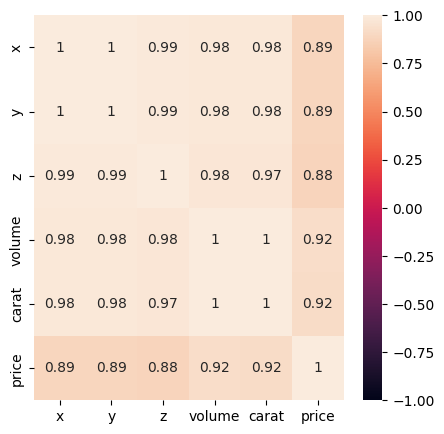

In [17]:
plt.figure(figsize=(5, 5))
sns.heatmap(df[['x', 'y', 'z', 'volume', 'carat', 'price']].corr(), annot=True,
            vmin=-1, vmax=1)
plt.show()

Volume is highly correlated to carats and price. As such, it represents a valuable combination of three features in one. This will be taken into consideration when selecting which features to use for the final predictive model.

Given the exponential-like distribution of price and carats, we compare them to the volume distribution by applying a lognorm transformation to them.

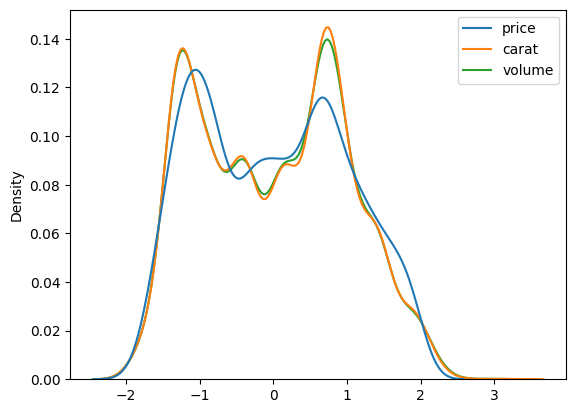

In [18]:
# Compute log values
log_price = np.log(df.price)
log_carat = np.log(df.carat)
log_volume = np.log(df.volume)

# Center and scale
lognorm_price = (log_price - log_price.mean()) / log_price.std()
lognorm_carat = (log_carat - log_carat.mean()) / log_carat.std()
lognorm_volume = (log_volume - log_volume.mean()) / log_volume.std()

sns.kdeplot(
    pd.DataFrame({'price': lognorm_price, 'carat': lognorm_carat,
                  'volume': lognorm_volume}))
plt.show()

It is possible to observe how similar the distributions are to each other, showing the two peaks.

### Cut and shape
Weirdly enough, exploring the correlation matrix displayed how the data is not showing a direct correlation between cut and diamond price. Since the general consensus considers the cut as the most important of the 4Cs, it is worth exploring it more in detail. Cut grade is determined by complex domain rules and considerations, involving the gem's proportions. Relative table width and pavilion depth are provided by Don Francesco's expert, but are they actually relevant? Or are they absorbed by the cut grade in the end?

Another property to take into consideration is the gem's shape. Visual inspection shows that *x* and *y* are very similar to each other, suggesting that the collection may comprise only round and/or square cuts (no ovals or other fancy cuts, etc.). We can get a clearer picture by extracting an eccentricity feature.

count    3991.000000
mean        0.086513
std         0.019965
min         0.000000
25%         0.073184
50%         0.083722
75%         0.097128
max         0.279946
Name: eccentricity, dtype: float64

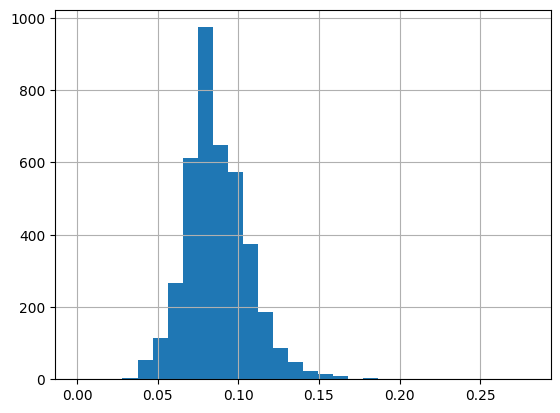

In [19]:
df['eccentricity'] = np.sqrt(1. - df[['x', 'y']].min(axis=1)
                             / df[['x', 'y']].max(axis=1))
df.eccentricity.hist(bins=30)
df.eccentricity.describe()

Aside from some isolated samples, eccentricity has particularly low mean and variance, suggesting that indeed nearly all gems in the collection are not oval cuts. While a large eccentricity may signal the presence of an elongated fancy cut, a minor eccentricity might just be a defect.

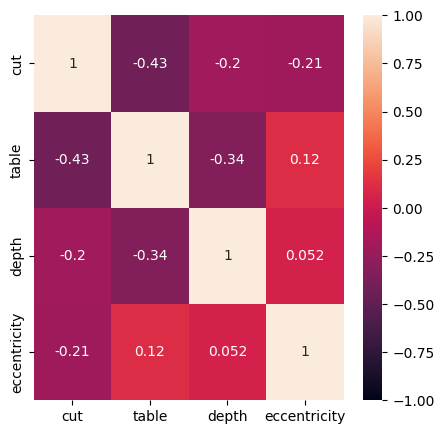

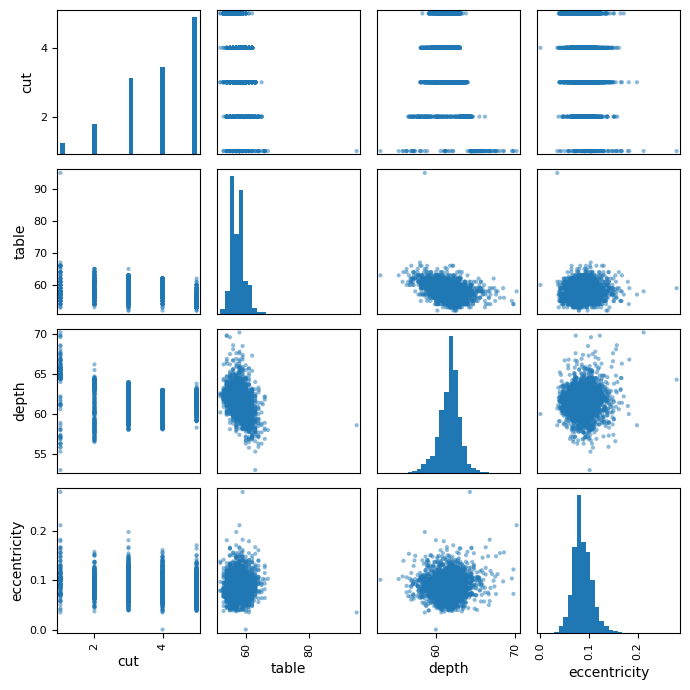

In [20]:
plt.figure(figsize=(5, 5))
sns.heatmap(df[['cut', 'table', 'depth', 'eccentricity']].corr(), annot=True,
            vmin=-1, vmax=1)
plt.show()

pd.plotting.scatter_matrix(df[['cut', 'table', 'depth', 'eccentricity']],
                           figsize=(7, 7), hist_kwds={'bins': 30})
plt.tight_layout()
plt.show()


Exploring correlations between cut grade and other relatable features such as table width, pavilion depth and eccentricity show some inverse correlation with the cut grade.

When considering table width and pavilion depth, it is important to remember that they usually have an ideal range, which is considerd desirable thanks to how the light is reflected. [Opinions on the web](https://beyond4cs.com/grading/depth-and-table-values/) are varied (here we would need a proper domain expert), but the general consensus sees an ideal table width of ~55% and an ideal pavilion depth of ~62%. Recalling Don Francesco's collection, we can see that the average values for depth and table are quite near the ideal ones.

In [21]:
df[['depth', 'table']].describe()

,depth,table
count,3991.000000,3991.000000
mean,61.719265,57.439312
std,1.425385,2.258569
min,53.000000,52.000000
25%,61.000000,56.000000
50%,61.799999,57.000000
75%,62.500000,59.000000
max,70.199997,95.000000


Inpsecting the scatter matrix, it is immediately clear how the range of pavilion depths is much more narrow for diamonds with a higher cut grade. This is expected for table width as well, even though the phenomenon is less present in Don Francesco's collection. In fact, the collection strongly penalizes higher table widths with respect to lower widths.

We can extract the "ideality" of the table width and pavilion depth by computing their distance from the mean value (nearly ideal).

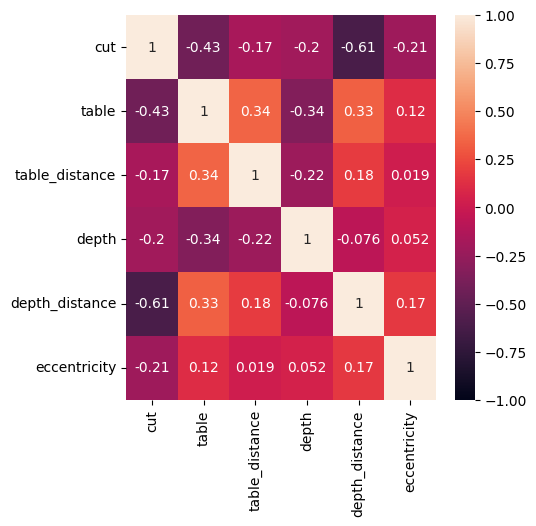

In [22]:
df = data.TableDistanceExtractor().fit_transform(df)
df = data.DepthDistanceExtractor().fit_transform(df)

plt.figure(figsize=(5, 5))
sns.heatmap(df[['cut', 'table', 'table_distance', 'depth', 'depth_distance',
                'eccentricity']].corr(), annot=True,
            vmin=-1, vmax=1)
plt.show()

The newly extracted feature `depth_distance` shows a strong correlation with the cut grade, which is expected. The table width counterpart (`table_distance`) is not conveying meaningful information apparently.

## Next
Data properties and feature relationships will be taken in considerations in order to build a predictive model.